In [46]:
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/corn_t2_kfold_dnn_separate.h5'

In [15]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)

2.4.1


In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(trueValues, predictions)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], c='red', label='Ideal best fit')
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [18]:
#url dataset
URL = "../Datasets/processed/Corn.csv"

#read in excel format
df = pd.read_csv(URL)

print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/Corn.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
0,0,HI BRED 31D58,6.0,3.3,26.23,0.5602,9.2688,142.982,-217.018,3.595,0.984
1,1,HI BRED 31D58,7.0,3.3,26.23,0.5602,11.9033,114.498,-245.502,3.476,1.067
2,2,HI BRED 31D58,8.0,3.3,26.23,0.5602,14.9916,85.785,-274.215,3.383,1.163
3,3,HI BRED 31D58,9.0,3.3,26.23,0.5602,17.7882,63.083,-296.917,3.252,1.205
4,4,HI BRED 31D58,10.0,3.3,26.23,0.5602,20.2646,38.844,-321.156,3.165,1.224


# 2. Overview of data


In [19]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
count,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000
mean,667.980377,9.616604,5.283170,19.173464,0.732730,18.574415,7.843992,-462.193766,3.241382,0.900775
std,388.591085,3.036191,2.049772,7.206516,0.101502,6.337757,89.287814,190.960971,0.603906,0.508211
min,0.000000,5.000000,2.000000,8.060000,0.448800,8.002300,-179.974000,-1115.206000,2.405000,0.242000
25%,331.000000,7.000000,3.300000,13.910000,0.663100,13.112200,-54.978000,-573.131000,2.780000,0.477000
50%,662.000000,9.000000,4.400000,18.580000,0.748300,18.344300,11.128000,-402.701000,3.094000,0.821000
75%,1007.000000,12.000000,7.700000,25.430000,0.816100,24.152200,77.870000,-323.806000,3.526000,1.213000
max,1338.000000,18.000000,8.500000,34.400000,0.901700,29.897000,179.949000,-150.217000,5.979000,3.294000


In [20]:
# Dimension of the dataset
df.shape

(1325, 11)

In [21]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [22]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary']]

# df_targets = df[['M%', 'Density']]
df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

In [23]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler = MinMaxScaler()
scaler_targets = MinMaxScaler()

# Perform column-wise normalization and scaling
X_normalized = scaler.fit_transform(dataset_x)
Y_normalized = scaler_targets.fit_transform(dataset_y)

## Splitting dataset to test and train+validate

In [24]:
# Perform train-test split on the normalized features
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y_normalized, 
                                                    test_size=0.1, 
                                                    random_state=42)

# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining the model

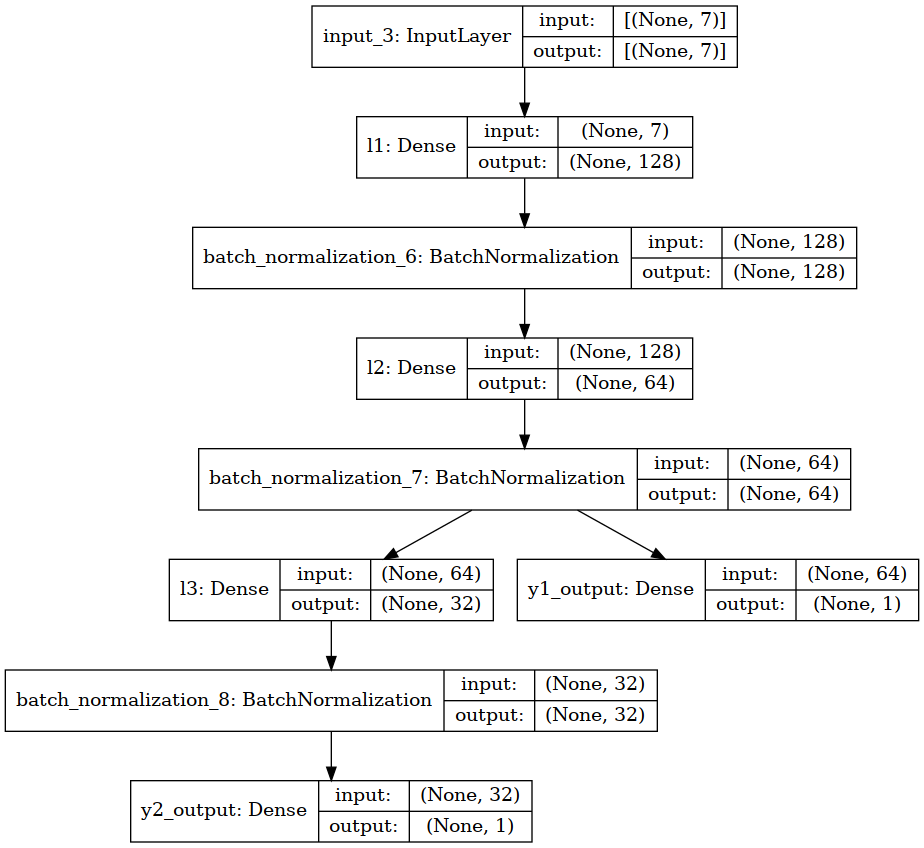

In [25]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  
    
  inputLayer = Input(shape=(7,))

  denseLayer1 =Dense(128, activation='relu', name='l1')(inputLayer)
  bn1 = BatchNormalization()(denseLayer1)

  denseLayer2 =Dense(64, activation='relu', name='l2')(bn1)
  bn2 = BatchNormalization()(denseLayer2)

  y1_output = Dense(1, activation = 'linear', name='y1_output')(bn2)

  denseLayer3 =Dense(32, activation='relu', name='l3')(bn2)
  bn3 = BatchNormalization()(denseLayer3)

  y2_output = Dense(1, activation = 'linear', name='y2_output')(bn3)
      
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

  my_model = Model(inputs = inputLayer,
                   outputs = [y1_output, y2_output])
  
  my_model.compile(
      optimizer = opt,
      loss = ['mse', 'mse'],
      metrics = {'y1_output':'accuracy', 'y2_output':'accuracy'},
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)

## Run KCV on model

In [49]:
from sklearn.model_selection import KFold
import numpy as np

K_FOLD_SPLITS = 2
NUM_EPOCHS = 10
BATCH_SIZE = 10

# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train[:,0]
Y2 = y_train[:,1]


X = X_train

i = 0
arr_loss = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, testX = np.array(X[train_indices]), np.array(X[test_indices])
  # trainY = np.vstack((Y1[train_indices], Y2[train_indices])).T
  # testY = np.vstack((Y1[test_indices], Y2[test_indices])).T
  trainY = (Y1[train_indices], Y2[train_indices])
  testY = (Y1[test_indices], Y2[test_indices])

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (testX, testY)
  )


  #testing on validation set process
  loss, Y1_loss, Y1_acc, Y2_loss, Y2_acc = model.evaluate(x = testX, y = testY, verbose=1)
  print(f"Loss = {loss}, Y1_loss = {Y1_loss}, Y1_rmse = {Y1_acc}, \n Y2_loss = {Y2_loss}, Y2_rmse = {Y2_acc}")

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Epoch 1/10
60/60 [==============================] - 1s 5ms/step - loss: 2.3659 - y1_output_loss: 1.1152 - y2_output_loss: 1.2507 - y1_output_accuracy: 0.0025 - y2_output_accuracy: 0.0239 - val_loss: 0.6234 - val_y1_output_loss: 0.4476 - val_y2_output_loss: 0.1757 - val_y1_output_accuracy: 0.0050 - val_y2_output_accuracy: 0.0302
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 1.3152 - y1_output_loss: 0.5837 - y2_output_loss: 0.7315 - y1_output_accuracy: 0.0071 - y2_output_accuracy: 0.0257 - val_loss: 0.4270 - val_y1_output_loss: 0.3263 - val_y2_output_loss: 0.1007 - val_y1_output_accuracy: 0.0050 - val_y2_output_accuracy: 0.0302
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 1.0361 - y1_output_loss: 0.4845 - y2_output_loss: 0.5515 - y1_output_accuracy: 0.0027 - y2_output_accuracy: 0.0183 - val_loss: 0.3523 - val_y1_output_loss: 0.2579 - val_y2_output_loss: 0.0944 - val_y1_outp

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [43]:
print(list(history_best_model.history.keys()))

['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_accuracy', 'y2_output_accuracy', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_accuracy', 'val_y2_output_accuracy']


No handles with labels found to put in legend.


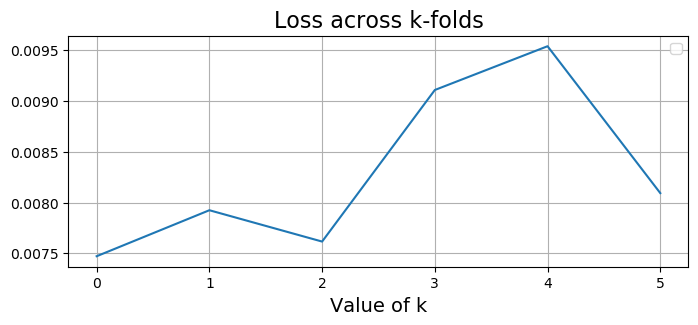

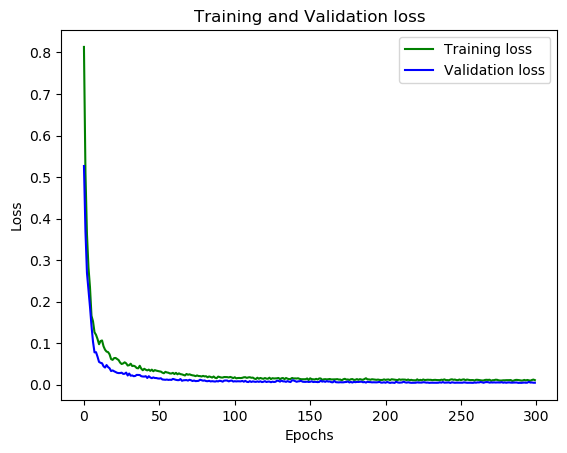

In [45]:
def plot_loss_curve(history, output_name, epoch_size):
    loss_train = history.history[output_name + '_loss']
    loss_val = history.history['val_' + output_name + '_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()



# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, 
                output_name='y1_output',
                epoch_size=NUM_EPOCHS)

## Inference

In [28]:
(pred_bc, pred_mc) = best_model.predict(X_test)
test_results = np.vstack( (pred_bc.flatten(), pred_mc.flatten()) ).T
Y_pred = scaler_targets.inverse_transform(test_results)

Y_actual = scaler_targets.inverse_transform(y_test)

## Plotting Real vs Predicted values

Maxval here is:  0.8930051
Maxval here is:  37.349632


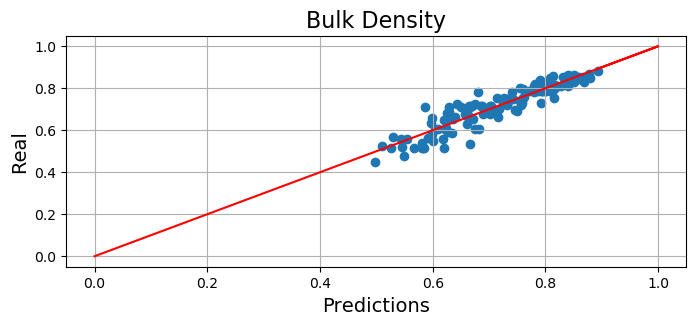

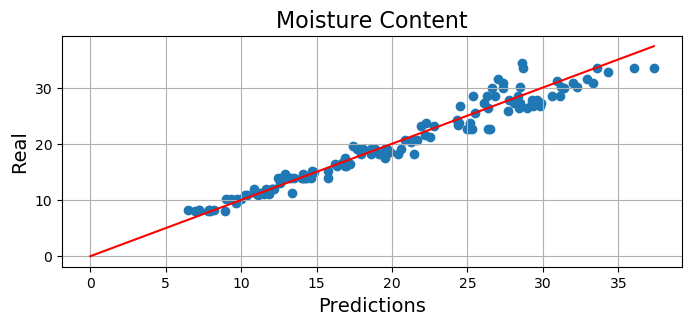

In [35]:
# BULK DENSITY
#    - find line of best fit
# a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
# x_best_fit = np.arange(0, 1, 0.1)
# plt.plot(x_best_fit, a*x_best_fit + b, c='blue', label='Best fit')
scatter_plot(Y_pred[:,0], Y_actual[:,0], "Bulk Density")
# plt.legend()

# MOISTURE CONTENT
#    - find line of best fit
# a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
# x_best_fit = np.arange(0, 100, 1)
# plt.plot(x_best_fit, a*x_best_fit + b, c='blue', label='Best fit')
scatter_plot(Y_pred[:,1], Y_actual[:,1], "Moisture Content")
# plt.legend()

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [30]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#    - find line of best fit
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b

#   - R-squared
mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
print(mc_r2_score)

# BULK DENSITY
#    - find line of best fit
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b

#   - R-squared
bd_r2_score = r2_score(Y_actual[:, 1], Y_pred[:, 1])
print(bd_r2_score)

0.8585837850450462
0.9508664207009084
